Ячейка кода ниже не работает, т.к. свой пароль я показывать никому не хочу!

В ней я сначала нахожу id друзей членов группы, потом друзей друзей и объёдиняю эти два словаря.


In [ ]:
import vk_api
import csv
import json


with open('users_id.csv', mode='r', encoding='utf-8-sig') as ids:
    reader = csv.reader(ids)
    ds_group = {rows[0]: int(rows[1]) for rows in reader}

with open(file='pass.txt', mode='r', encoding='UTF-8') as passwords:
    for line in passwords:
        login = line.split()[0]
        password = line.split()[1]


def auth_handler():

    key = input("Enter authentication code: ")
    remember_device = True

    return key, remember_device


my_session = vk_api.VkApi(login=login, password=password, auth_handler=auth_handler)
my_session.auth(token_only=True)

friends = {}
with vk_api.VkRequestsPool(my_session) as pool:
    for user_id in ds_group.values():
        friends[user_id] = pool.method('friends.get', {
            'user_id': user_id,
        })

for key, value in friends.items():
    if value.ok:
        friends[key] = tuple(value.result['items'])
    else:
        friends[key] = []

friends_of_friends = {}
with vk_api.VkRequestsPool(my_session) as pool:
    for ids in friends.values():
        for user_id in ids:
            friends_of_friends[user_id] = pool.method('friends.get', {
                'user_id': user_id,
            })

for key, value in friends_of_friends.items():
    if value.ok:
        friends_of_friends[key] = tuple(value.result['items'])
    else:
        friends_of_friends[key] = []

complete_graph = {**friends, **friends_of_friends}
complete_graph = {str(key): value for key, value in complete_graph.items() if value != []}
print(len(complete_graph))
with open(file='graph.json', mode='w', encoding='utf-8') as graph:
    json.dump(complete_graph, graph)


Анализ графов; ds_group просто скопировал из предыдущего блока, т.к. без пароля тот не работает

In [6]:
import networkx as nx
import json
import matplotlib.pyplot as plt
ds_group = {'Липин Роман Андреевич': 325969137, 'Беляков Николай Николаевич': 380898246,
            'Сучков Артём Дмитриевич': 404306503, 'Беляева Татьяна': 258835769,
            'Алферова Ирина Александровна': 166690832, 'Никитин Павел Александрович': 127123318,
            'Денисова Анна Игоревна': 612775359, 'Глухарева Елизавета Семеновна': 474222811,
            'Люльчак Павел Игоревич': 284809767, 'Юрлов Даниил Андреевич': 226972714,
            'Анисимов Никита Станиславович': 222323979, 'Еременко Анастасия Юрьевна': 481812303,
            'Сидоренко Александра Владимировна': 163926270, 'Орешников Даниил Борисович': 339103624,
            'Ширинова Рена Афраил кызы': 187132254, 'Бусел Татьяна Васильевна': 161142420,
            'Тенькаев Захар Валерьевич': 509082391}



In [7]:
with open(file='graph.json', mode='r', encoding='utf-8') as graph:
    friends_dict = json.load(graph)

friends_dict = {int(key): tuple(value) for key, value in friends_dict.items()}

ds_group = {value: key for key, value in ds_group.items() if value in friends_dict.keys()}
Graph_of_friends = nx.Graph(friends_dict)

print(len(friends_dict))



1758


In [8]:
print(len(list(Graph_of_friends.nodes)))
low_degree = [n for n, d in Graph_of_friends.degree() if d < 5]
Graph_of_friends.remove_nodes_from(low_degree)
print(len(list(Graph_of_friends.nodes)))


459075
11367


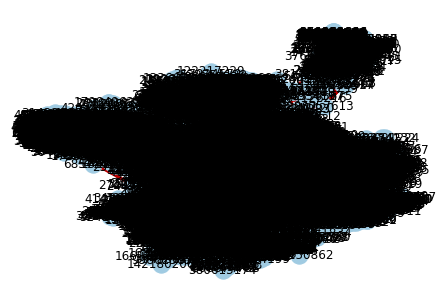

In [9]:
pos = nx.spring_layout(Graph_of_friends)
nx.draw(Graph_of_friends, pos,node_color='#A0CBE2'
        ,edge_color='#BB0000',width=2,
        edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph.png", dpi=1000, facecolor='w', edgecolor='w',orientation='portrait', format=None,transparent=False, bbox_inches=None, pad_inches=0.1)

In [ ]:
degree_centrality_dict = {key: value for key, value 
                          in nx.degree_centrality(Graph_of_friends).items()
                          if key in ds_group.keys()}
betweenness_centrality_dict = {key: value for key, value 
                               in nx.betweenness_centrality(Graph_of_friends, k=10).items()
                               if key in ds_group.keys()}
eigenvector_centrality_dict = {key: value for key, value 
                               in nx.eigenvector_centrality(Graph_of_friends).items()
                               if key in ds_group.keys()}
pagerank_dict = {key: value for key, value 
                 in nx.pagerank(Graph_of_friends).items()
                 if key in ds_group.keys()}
closeness_centrality_dict = {key: nx.closeness_centrality(Graph_of_friends, u=key) for key 
                             in ds_group.keys()}


                             

In [ ]:
print('Лидеры\n')
print('Центральность по близости:',
    ds_group[max(closeness_centrality_dict, key=closeness_centrality_dict.get)])
print('Степенная центральность:',
    ds_group[max(degree_centrality_dict, key=degree_centrality_dict.get)])
print('Центральность по посредничеству:',
    ds_group[max(betweenness_centrality_dict, key=betweenness_centrality_dict.get)])
print('Центральность по собственному вектору:',
    ds_group[max(eigenvector_centrality_dict, key=eigenvector_centrality_dict.get)])
print('Центральность PageRank:',
    ds_group[max(pagerank_dict, key=pagerank_dict.get)])

Лидеры

Центральность по близости: Беляева Татьяна
Степенная центральность: Липин Роман Андреевич
Центральность по посредничеству: Липин Роман Андреевич
Центральность по собственному вектору: Беляева Татьяна
Центральность PageRank: Никитин Павел Александрович
